<a href="https://colab.research.google.com/github/linyubo/CE888code/blob/main/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

In [112]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv", delimiter=";")

df.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [113]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [114]:
le = LabelEncoder()
le.fit(df['y'])
df['y'] = le.transform(df['y'])
le.fit(df['job'])
df['job'] = le.transform(df['job'])
le.fit(df['marital'])
df['marital'] = le.transform(df['marital'])
le.fit(df['education'])
df['education'] = le.transform(df['education'])
le.fit(df['default'])
df['default'] = le.transform(df['default'])
le.fit(df['housing'])
df['housing'] = le.transform(df['housing'])
le.fit(df['loan'])
df['loan'] = le.transform(df['loan'])
le.fit(df['contact'])
df['contact'] = le.transform(df['contact'])
le.fit(df['month'])
df['month'] = le.transform(df['month'])
le.fit(df['day_of_week'])
df['day_of_week'] = le.transform(df['day_of_week'])
le.fit(df['poutcome'])
df['poutcome'] = le.transform(df['poutcome'])
df_dummies = pd.get_dummies(df)
df = df.drop('duration',axis = 1)# Drop the duration
#Plot histogram of the label and calculate the imbalance in the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  int64  
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

# New section

In [115]:
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,3.72458,1.172769,3.747184,0.208872,1.071720,0.327425,0.365252,4.230868,2.004613,2.567593,962.475454,0.172963,0.930101,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,3.59456,0.608902,2.136482,0.406686,0.985314,0.723616,0.481507,2.320025,1.397575,2.770014,186.910907,0.494901,0.362886,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,999.000000,0.000000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.00000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,2.000000,999.000000,0.000000,1.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,7.00000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,3.000000,999.000000,0.000000,1.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.00000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,56.000000,999.000000,7.000000,2.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


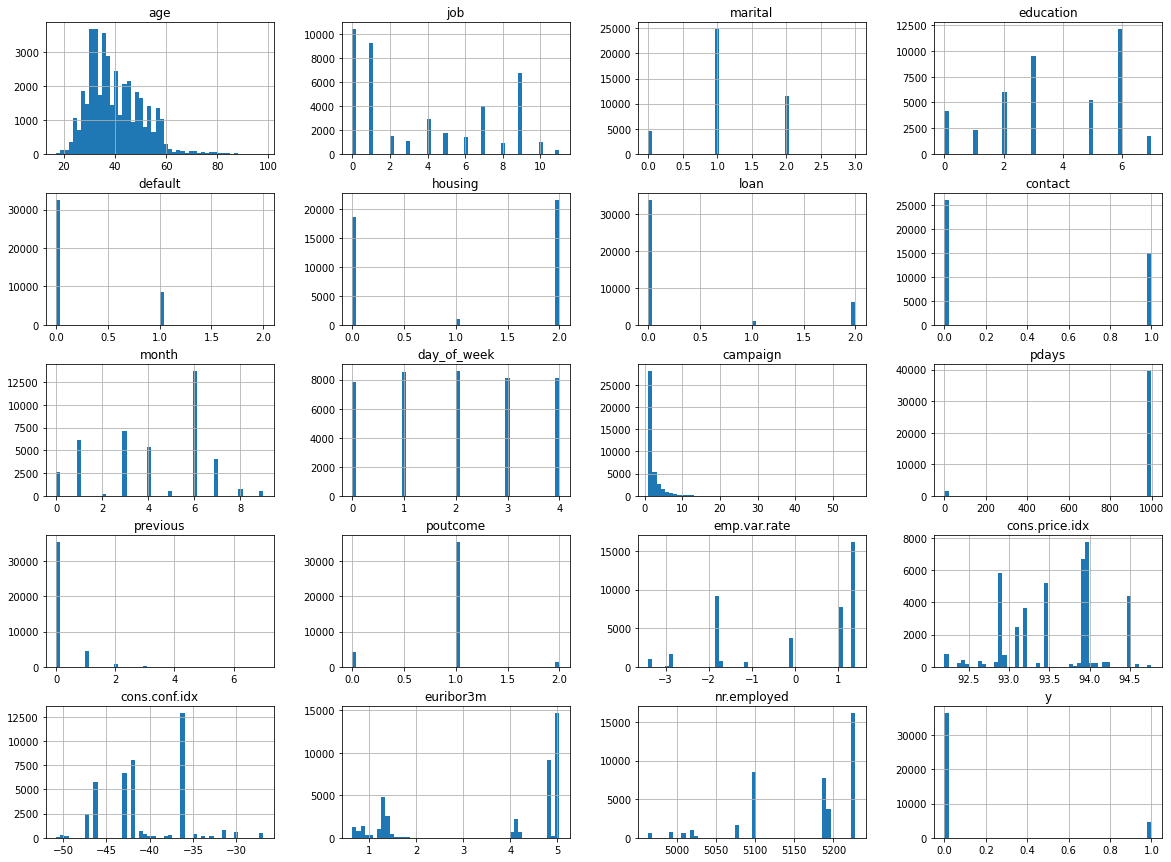

In [116]:
_ = df.hist(bins=50, figsize=(20,15))

In [128]:
print(df['y'])

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64


In [118]:
imbalance_rate = sum(df['y']==1)/len(df['y'])#imbalance
print(imbalance_rate)

0.11265417111780131


In [143]:
import sklearn
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [119]:
class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [130]:
y = df['y']
X = df.drop('y',axis=1)
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

X= X.values
y= y.values
#y_a = (y_a - y_a.min())/(y_a.max() - y_a.min()) # This is a min-max scaler (the output will be between 0--1)
#clf = DecisionTreeRegressor()
#clf.fit(X_a, y_a)
#print("MSE = ", mse(y_a, clf.predict(X_a))) # Mean Squared Error

In [131]:
print(X)

[[ 5.6000e+01  3.0000e+00  1.0000e+00 ... -3.6400e+01  4.8570e+00
   5.1910e+03]
 [ 5.7000e+01  7.0000e+00  1.0000e+00 ... -3.6400e+01  4.8570e+00
   5.1910e+03]
 [ 3.7000e+01  7.0000e+00  1.0000e+00 ... -3.6400e+01  4.8570e+00
   5.1910e+03]
 ...
 [ 5.6000e+01  5.0000e+00  1.0000e+00 ... -5.0800e+01  1.0280e+00
   4.9636e+03]
 [ 4.4000e+01  9.0000e+00  1.0000e+00 ... -5.0800e+01  1.0280e+00
   4.9636e+03]
 [ 7.4000e+01  5.0000e+00  1.0000e+00 ... -5.0800e+01  1.0280e+00
   4.9636e+03]]


In [151]:
estimator = RandomForestRegressor()
clf = RandomForestRegressor(n_estimators=400, max_depth=6)
dummy_clf = DummyRegressor(strategy='mean') # always predicts the mean of the training set
scores = cross_val_score(clf, X, y, cv=10, scoring=make_scorer(mse))
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring=make_scorer(mse))
print("MSE: %.8f +/- %.8f" % (scores.mean(), scores.std()))
print("Dummy MSE: %.8f +/- %.8f" % (dummy_scores.mean(), dummy_scores.std()))


MSE: 0.08351029 +/- 0.06176101
Dummy MSE: 0.10345690 +/- 0.10218101


In [180]:
clf =  ExtraTreesClassifier(n_estimators=1200, max_depth=4)
dummy_clf = DummyClassifier(strategy="stratified") # generates predictions by respecting the training set's class distribution
scores = cross_val_score(clf, X, y, cv=10,scoring=make_scorer(acc))
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring=make_scorer(acc))
print("ACC: %0.2f +/- %0.2f" % (scores.mean(), scores.std()))
print("Dummy ACC: %0.2f +/- %0.2f" % (dummy_scores.mean(), dummy_scores.std()))

ACC: 0.84 +/- 0.17
Dummy ACC: 0.80 +/- 0.00


In [156]:
features = df.columns
outcomes_of_interest = df.columns
n_bins = 20
X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()
bins = pd.qcut(y_df[outcomes_of_interest[0]].values,n_bins)
y_df = df[outcomes_of_interest].copy()
y_df[outcomes_of_interest[0]] = bins
y_df[outcomes_of_interest] = y_df[outcomes_of_interest].apply(LabelEncoder().fit_transform)

Feature ranking:
1. euribor3m (0.166453)
2. nr.employed (0.135282)
3. pdays (0.105267)
4. age (0.086483)
5. poutcome (0.062545)
6. cons.conf.idx (0.060354)
7. emp.var.rate (0.049148)
8. cons.price.idx (0.046409)
9. job (0.041172)
10. campaign (0.039588)
11. day_of_week (0.038393)
12. education (0.037391)
13. month (0.034893)
14. contact (0.020036)
15. marital (0.019758)
16. previous (0.019142)
17. housing (0.016555)
18. loan (0.014080)
19. default (0.007053)


(0.0, 0.31095201177108533)

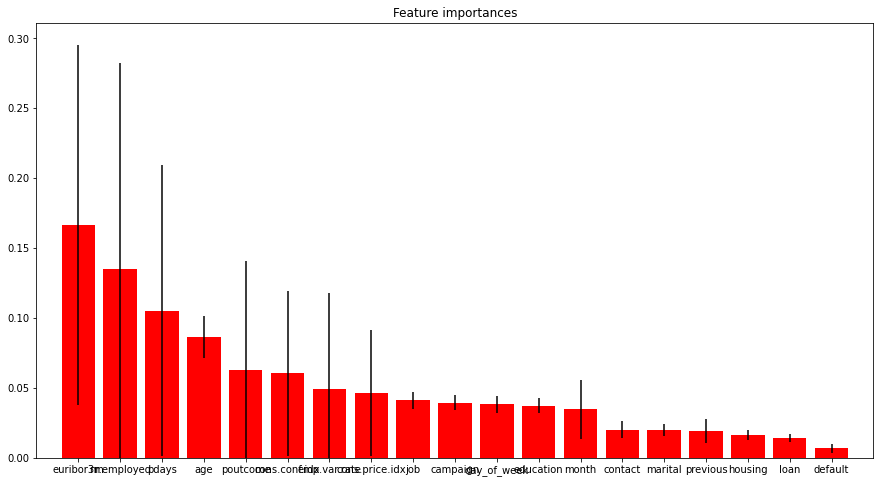

In [159]:
clf.fit(X,y)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices])
plt.xlim([-1, X.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])


In [160]:
import pickle as pkl

outp = open('model.pkl', 'wb')
pkl.dump(clf, outp, -1)  # where clf is your classifier
outp.close()

In [167]:
df.to_csv('testset.csv')